# VLM Training with PixMo QA Dataset

This notebook implements a **Vision-Language Model for Question Answering** using:
1. Modular vision encoder (CLIP + Perceiver + MRL) from `edge_glass_modular/src/encoders`
2. Qwen decoder with LoRA from `edge_glass_modular/src/decoders`
3. PixMo QA dataset with question-answer pairs
4. Proper modular design following the edge_glass_modular architecture

## Architecture:

```
Image (B, 3, 336, 336)
  ↓
Vision Encoder (frozen aligned model)
  ↓ (B, num_latents, hidden_dim)
Projection to Qwen hidden dim
  ↓ (B, num_latents, qwen_dim)
Qwen Decoder with LoRA (trainable)
  ↓
Token Layout: [IMG_TOKENS] [QUESTION_TOKENS] [ANSWER_TOKENS]
  ↓
Loss on answer tokens only
```

## Key Features:
- Modular design using imports from `edge_glass_modular/src`
- Frozen aligned vision encoder
- Qwen2.5 decoder with LoRA fine-tuning
- Real QA dataset (not synthetic)
- Proper configuration management

## 1. Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / "src"))
Path.cwd().parent / "src"

PosixPath('/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular/src')

In [3]:
# Import standard libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import wandb
from pathlib import Path
from typing import Optional, Dict, List
from collections import Counter
import string
import warnings

# Import modular components from edge_glass_modular
from config import load_config
from encoders.vision import VisionEncoder
from decoders.qwen import QwenDecoder
from data.dataset_builder import PixmoParquetImageTextDataset
from data.transforms import get_image_transforms
from models.alignment import MultimodalAlignmentModel

from transformers import AutoTokenizer


# Set up matplotlib
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA H200
GPU Memory: 150.11 GB
Using device: cuda


## 2. Load Configuration

Load the experiment configuration from YAML file.

In [4]:
# Load configuration
config_path = "../configs/trm_vlm_qa.yaml"
config = load_config(config_path)

print(f"Loaded config: {config.name}")
print(f"\nDataset:")
print(f"  Train parquet: {config.dataset.train_parquet}")
print(f"  Val parquet: {config.dataset.val_parquet}")
print(f"  Test parquet: {config.dataset.test_parquet}")
print(f"  Image size: {config.dataset.image_size}")
print(f"  Max question length: {config.dataset.max_question_length}")
print(f"  Max answer length: {config.dataset.max_answer_length}")
print(f"  Batch size: {config.dataset.batch_size}")

print(f"\nDecoder:")
print(f"  Type: {config.decoder.type}")
print(f"  Model: {config.decoder.model_name}")
print(f"  Use LoRA: {config.decoder.use_lora}")
print(f"  Load in 8bit: {config.decoder.load_in_8bit}")

Loaded config: trm_vlm_qa

Dataset:
  Train parquet: /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo_alignment/pixmo_qa_mixed_train.parquet
  Val parquet: /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo_alignment/pixmo_qa_mixed_val.parquet
  Test parquet: /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo_alignment/pixmo_qa_mixed_test.parquet
  Image size: 336
  Max question length: 128
  Max answer length: 256
  Batch size: 16

Decoder:
  Type: qwen
  Model: Qwen/Qwen2.5-7B-Instruct
  Use LoRA: True
  Load in 8bit: False


## 3. Load Aligned Vision Encoder

Load the pretrained Perceiver+MRL alignment model and freeze it.

In [5]:
# Load alignment config
alignment_config_path = "../configs/pixmo_alignment.yaml"
alignment_config = load_config(alignment_config_path)

# Load aligned model
aligned_model = MultimodalAlignmentModel(alignment_config).to(device)

# Load checkpoint
checkpoint_path = "checkpoints/pixmo_alignment/checkpoint_best.pt"
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
aligned_model.load_state_dict(checkpoint['model_state_dict'])
aligned_model.eval()

# Freeze all parameters
for param in aligned_model.parameters():
    param.requires_grad = False

print(f"Loaded aligned model from {checkpoint_path}")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Val loss: {checkpoint['best_val_loss']:.4f}")
print(f"  Vision encoder output: (B, 64, 4096)")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273
Loaded aligned model from checkpoints/pixmo_alignment/checkpoint_best.pt
  Epoch: 0
  Val loss: 0.0000
  Vision encoder output: (B, 64, 4096)


## 4. Extract Vision Encoder Method

Create a clean interface to get vision embeddings.

In [6]:
@torch.no_grad()
def encode_images(images: torch.Tensor) -> torch.Tensor:
    """Encode images to vision tokens.
    
    Args:
        images: (B, 3, H, W)
    
    Returns:
        vision_tokens: (B, num_latents, 4096)
    """
    vision_output = aligned_model.vision_encoder(images, return_sequence=True)
    if vision_output.sequence is None:
        raise ValueError("Vision encoder did not return sequence embeddings")
    # Get sequence output (B, num_latents, dim)
    return vision_output.sequence

# Test
test_img = torch.randn(2, 3, 336, 336).to(device)
test_vision_tokens = encode_images(test_img)
print(f"Vision tokens shape: {test_vision_tokens.shape}")
if getattr(aligned_model.vision_encoder, "use_perceiver", False):
    expected_tokens = aligned_model.config.vision_encoder.perceiver_num_latents
else:
    expected_tokens = test_vision_tokens.shape[1]
print(f"Expected: ({test_img.shape[0]}, {expected_tokens}, {aligned_model.config.vision_encoder.projection_dim})")

Vision tokens shape: torch.Size([2, 577, 4096])
Expected: (2, 577, 4096)


## 5. Implement Plain Tiny Decoder Baseline

First, implement a simple baseline decoder without TRM recursion.

In [7]:
from decoders.trm import TRMConfig, TRMDecoder

class TinyVLMDecoder(nn.Module):
    """Plain tiny decoder baseline for VLM.
    
    Architecture:
        - Projects vision tokens from 4096 -> d_dec
        - Token layout: [IMG_TOKENS] [QUESTION_TOKENS] [ANSWER_TOKENS]
        - Causal masking
        - Loss only on answer tokens
    """
    
    def __init__(
        self,
        vocab_size: int,
        hidden_dim: int = 512,
        num_layers: int = 4,
        num_heads: int = 8,
        vision_token_dim: int = 4096,
        max_seq_len: int = 256,
    ):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.vision_token_dim = vision_token_dim
        
        # Project vision tokens to decoder dim
        self.vision_proj = nn.Linear(vision_token_dim, hidden_dim)
        
        # TRM decoder
        trm_config = TRMConfig(
            vocab_size=vocab_size,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_heads=num_heads,
            max_seq_len=max_seq_len,
        )
        self.decoder = TRMDecoder(trm_config)
    
    def forward(
        self,
        vision_tokens: torch.Tensor,  # (B, K_img, 4096)
        question_ids: torch.Tensor,   # (B, L_q)
        answer_ids: torch.Tensor,     # (B, L_a)
    ):
        """Forward pass with proper token layout and loss masking.
        
        Token layout: [IMG_TOKENS] [QUESTION_TOKENS] [ANSWER_TOKENS]
        Loss only on answer tokens.
        """
        batch_size = vision_tokens.shape[0]
        num_img_tokens = vision_tokens.shape[1]
        
        # Project vision tokens
        vision_emb = self.vision_proj(vision_tokens)  # (B, K_img, d_dec)
        
        # Embed question and answer tokens
        question_emb = self.decoder.embed_tokens(question_ids)  # (B, L_q, d_dec)
        answer_emb = self.decoder.embed_tokens(answer_ids)      # (B, L_a, d_dec)
        
        # Concatenate: [vision | question | answer]
        full_sequence = torch.cat([vision_emb, question_emb, answer_emb], dim=1)
        
        # Create labels: -100 for image and question tokens, actual IDs for answer
        img_labels = torch.full(
            (batch_size, num_img_tokens),
            fill_value=-100,
            dtype=torch.long,
            device=vision_tokens.device
        )
        question_labels = torch.full_like(question_ids, fill_value=-100)
        answer_labels = answer_ids
        
        # Concatenate labels
        full_labels = torch.cat([img_labels, question_labels, answer_labels], dim=1)
        
        # Pass through decoder layers
        hidden_states = full_sequence
        for layer in self.decoder.layers:
            hidden_states = layer(hidden_states)
        
        hidden_states = self.decoder.norm(hidden_states)
        logits = self.decoder.lm_head(hidden_states)
        
        # Compute loss (shift for next-token prediction)
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = full_labels[:, 1:].contiguous()
        
        loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        
        return {
            'loss': loss,
            'logits': logits,
        }
    
    @torch.no_grad()
    def generate(
        self,
        vision_tokens: torch.Tensor,
        question_ids: torch.Tensor,
        max_new_tokens: int = 32,
        temperature: float = 0.7,
    ):
        """Generate answer tokens autoregressively."""
        batch_size = vision_tokens.shape[0]
        
        # Project vision
        vision_emb = self.vision_proj(vision_tokens)
        question_emb = self.decoder.embed_tokens(question_ids)
        
        # Start with image + question
        current_emb = torch.cat([vision_emb, question_emb], dim=1)
        generated_ids = []
        
        for _ in range(max_new_tokens):
            # Forward pass
            hidden = current_emb
            for layer in self.decoder.layers:
                hidden = layer(hidden)
            hidden = self.decoder.norm(hidden)
            logits = self.decoder.lm_head(hidden)
            
            # Sample next token
            next_token_logits = logits[:, -1, :] / temperature
            next_token = torch.argmax(next_token_logits, dim=-1)
            
            generated_ids.append(next_token)
            
            # Embed and append
            next_emb = self.decoder.embed_tokens(next_token.unsqueeze(1))
            current_emb = torch.cat([current_emb, next_emb], dim=1)
        
        return torch.stack(generated_ids, dim=1)

## 6. Implement TRM-Style Recursive Decoder

Now implement the TRM version with latent recursion.

In [8]:
class TRMVLMWithConfidence(nn.Module):
    """TRM VLM decoder with confidence-based recursive refinement.
    
    Key features:
    - Uses aligned vision encoder (frozen)
    - Projects vision tokens to TRM hidden dim
    - Implements latent recursion for reasoning
    - Confidence-based early stopping
    """
    
    def __init__(
        self,
        vocab_size: int,
        vision_token_dim: int = 4096,
        hidden_dim: int = 512,
        num_layers: int = 2,
        num_heads: int = 8,
        num_inner_steps: int = 4,
        confidence_threshold: float = 0.8,
    ):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_inner_steps = num_inner_steps
        self.confidence_threshold = confidence_threshold
        
        # Project vision tokens to decoder dim
        self.vision_proj = nn.Linear(vision_token_dim, hidden_dim)
        
        # Token embeddings
        self.embed_tokens = nn.Embedding(vocab_size, hidden_dim)
        
        # Tiny transformer for recursion (use TRM components)
        from decoders.trm import TRMConfig, TRMLayer
        
        trm_config = TRMConfig(
            vocab_size=vocab_size,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_heads=num_heads,
            max_seq_len=1024,
        )
        
        self.tiny_transformer = nn.ModuleList([
            TRMLayer(trm_config) for _ in range(num_layers)
        ])
        
        from decoders.trm import RMSNorm
        self.norm = RMSNorm(hidden_dim)
        
        # LM head
        self.lm_head = nn.Linear(hidden_dim, vocab_size, bias=False)
        self.lm_head.weight = self.embed_tokens.weight  # Tie weights
        
        # Learned initial z state
        self.z_init = nn.Parameter(torch.randn(1, 1, hidden_dim) * 0.02)
    
    def latent_recursion(
        self,
        x: torch.Tensor,  # Context: (B, L_ctx, d)
        y: torch.Tensor,  # Answer: (B, L_ans, d)
        z: torch.Tensor,  # Latent: (B, L_ans, d)
    ):
        """Single step of latent recursion."""
        # Concatenate along sequence: [x, y, z]
        concat = torch.cat([x, y, z], dim=1)  # (B, L_ctx + 2*L_ans, d)
        
        # Pass through tiny transformer
        hidden = concat
        for layer in self.tiny_transformer:
            hidden = layer(hidden)
        
        # Split back
        L_ctx = x.shape[1]
        L_ans = y.shape[1]
        
        x_out = hidden[:, :L_ctx, :]
        y_out = hidden[:, L_ctx:L_ctx+L_ans, :]
        z_out = hidden[:, L_ctx+L_ans:, :]
        
        return x_out, y_out, z_out
    
    def compute_confidence(self, logits: torch.Tensor) -> torch.Tensor:
        """Compute confidence score from logits.
        
        Args:
            logits: (B, L, vocab_size)
        
        Returns:
            confidence: (B,) - mean max softmax probability
        """
        probs = torch.softmax(logits, dim=-1)
        max_probs = torch.max(probs, dim=-1)[0]  # (B, L)
        confidence = torch.mean(max_probs, dim=-1)  # (B,)
        return confidence
    
    def forward(
        self,
        vision_tokens: torch.Tensor,  # (B, K_img, 4096)
        question_ids: torch.Tensor,   # (B, L_q)
        answer_ids: torch.Tensor,     # (B, L_a)
        num_recursion_steps: Optional[int] = None,
    ):
        """Forward pass with TRM recursion."""
        batch_size = vision_tokens.shape[0]
        L_ans = answer_ids.shape[0]
        
        # Use default or override recursion steps
        n_steps = num_recursion_steps if num_recursion_steps is not None else self.num_inner_steps
        
        # Project vision tokens
        vision_emb = self.vision_proj(vision_tokens)  # (B, K_img, d)
        
        # Embed question
        question_emb = self.embed_tokens(question_ids)  # (B, L_q, d)
        
        # Context x = [vision | question]
        x = torch.cat([vision_emb, question_emb], dim=1)  # (B, L_ctx, d)
        
        # Teacher-forced answer embeddings
        y = self.embed_tokens(answer_ids)  # (B, L_ans, d)
        
        # Initialize latent z
        z = self.z_init.expand(batch_size, answer_ids.shape[1], -1)  # (B, L_ans, d)
        
        # Inner recursion (n steps)
        for _ in range(n_steps):
            x, y, z = self.latent_recursion(x, y, z)
        
        # Final answer from y
        y = self.norm(y)
        logits = self.lm_head(y)  # (B, L_ans, vocab_size)
        
        # Compute loss (standard next-token prediction on answer)
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = answer_ids[:, 1:].contiguous()
        
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        
        # Compute confidence
        confidence = self.compute_confidence(logits)
        
        return {
            'loss': loss,
            'logits': logits,
            'confidence': confidence,
        }
    
    @torch.no_grad()
    def generate(
        self,
        vision_tokens: torch.Tensor,
        question_ids: torch.Tensor,
        max_new_tokens: int = 32,
        temperature: float = 0.7,
        use_confidence: bool = True,
    ):
        """Generate answer with confidence-based recursion."""
        batch_size = vision_tokens.shape[0]
        
        # Context
        vision_emb = self.vision_proj(vision_tokens)
        question_emb = self.embed_tokens(question_ids)
        x = torch.cat([vision_emb, question_emb], dim=1)
        
        # Start with empty answer
        generated_ids = []
        confidence_scores = []
        recursion_steps_used = []
        
        # Generate autoregressively
        for step in range(max_new_tokens):
            # Current y from generated so far
            if len(generated_ids) == 0:
                # First token: use learned blank
                y = torch.zeros(batch_size, 1, self.hidden_dim, device=x.device)
                z = self.z_init.expand(batch_size, 1, -1)
            else:
                y = self.embed_tokens(torch.stack(generated_ids, dim=1))
                z = self.z_init.expand(batch_size, len(generated_ids), -1)
            
            # Adaptive recursion based on confidence
            if use_confidence and len(generated_ids) > 0:
                # Run once to check confidence
                x_temp, y_temp, z_temp = self.latent_recursion(x, y, z)
                y_normed = self.norm(y_temp)
                logits_temp = self.lm_head(y_normed[:, -1, :])
                conf = self.compute_confidence(logits_temp.unsqueeze(1))
                
                if conf.mean() >= self.confidence_threshold:
                    # High confidence - use result
                    y = y_temp
                    num_steps = 1
                else:
                    # Low confidence - run more recursion
                    y = y_temp
                    z = z_temp
                    for _ in range(self.num_inner_steps - 1):
                        x_temp, y, z = self.latent_recursion(x, y, z)
                    num_steps = self.num_inner_steps
                
                recursion_steps_used.append(num_steps)
            else:
                # Fixed recursion
                for _ in range(self.num_inner_steps):
                    x_temp, y, z = self.latent_recursion(x, y, z)
                recursion_steps_used.append(self.num_inner_steps)
            
            # Get logits for last position
            y = self.norm(y)
            logits = self.lm_head(y[:, -1, :]) / temperature
            next_token = torch.argmax(logits, dim=-1)
            
            # Track confidence
            conf = self.compute_confidence(logits.unsqueeze(1))
            confidence_scores.append(conf.mean().item())
            
            generated_ids.append(next_token)
            
            # Stop at EOS (optional)
            # if (next_token == tokenizer.eos_token_id).all():
            #     break
        
        return {
            'ids': torch.stack(generated_ids, dim=1),
            'confidence': confidence_scores,
            'recursion_steps': recursion_steps_used,
        }

print("TRM VLM with Confidence-Based Recursion defined.")

TRM VLM with Confidence-Based Recursion defined.


## 7. Evaluation Metrics (EM and F1)

In [9]:
def normalize_answer(s: str) -> str:
    """Normalize answer text for evaluation."""
    # Remove punctuation
    s = ''.join(ch for ch in s if ch not in string.punctuation)
    # Lowercase and strip
    s = s.lower().strip()
    # Remove articles
    s = ' '.join([w for w in s.split() if w not in {'a', 'an', 'the'}])
    return s

def compute_exact_match(pred: str, target: str) -> float:
    """Compute exact match score."""
    return float(normalize_answer(pred) == normalize_answer(target))

def compute_f1(pred: str, target: str) -> float:
    """Compute token-level F1 score."""
    pred_tokens = normalize_answer(pred).split()
    target_tokens = normalize_answer(target).split()
    
    if len(pred_tokens) == 0 or len(target_tokens) == 0:
        return float(pred_tokens == target_tokens)
    
    common = Counter(pred_tokens) & Counter(target_tokens)
    num_common = sum(common.values())
    
    if num_common == 0:
        return 0.0
    
    precision = num_common / len(pred_tokens)
    recall = num_common / len(target_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    
    return f1

def evaluate_qa(
    predictions: List[str],
    targets: List[str],
) -> Dict[str, float]:
    """Evaluate QA predictions."""
    em_scores = [compute_exact_match(p, t) for p, t in zip(predictions, targets)]
    f1_scores = [compute_f1(p, t) for p, t in zip(predictions, targets)]
    
    return {
        'em': np.mean(em_scores) * 100,
        'f1': np.mean(f1_scores) * 100,
    }

## 8. Setup Dataset and Dataloaders

In [10]:
# Initialize tokenizer (use GPT2 tokenizer)
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"Pad token: {tokenizer.pad_token}")
print(f"EOS token: {tokenizer.eos_token}")

# Get transforms
train_transforms = get_image_transforms(image_size=336, is_training=True)
val_transforms = get_image_transforms(image_size=336, is_training=False)

Tokenizer vocab size: 50257
Pad token: <|endoftext|>
EOS token: <|endoftext|>


In [11]:
# Import QA dataset
from data.dataset_builder import PixmoQADataset

# Define collate function for QA batches
def collate_qa_batch(batch):
    """Collate QA batch with padding."""
    # Stack images
    images = torch.stack([item['image'] for item in batch])
    
    # Pad question_ids
    question_ids = [item['question_ids'] for item in batch]
    max_q_len = max(q.shape[0] for q in question_ids)
    question_ids_padded = torch.stack([
        torch.cat([q, torch.full((max_q_len - q.shape[0],), tokenizer.pad_token_id, dtype=torch.long)])
        for q in question_ids
    ])
    
    # Pad answer_ids
    answer_ids = [item['answer_ids'] for item in batch]
    max_a_len = max(a.shape[0] for a in answer_ids)
    answer_ids_padded = torch.stack([
        torch.cat([a, torch.full((max_a_len - a.shape[0],), tokenizer.pad_token_id, dtype=torch.long)])
        for a in answer_ids
    ])
    
    # Get raw text
    questions = [item['question'] for item in batch]
    answers = [item['answer'] for item in batch]
    
    return {
        'images': images,
        'question_ids': question_ids_padded,
        'answer_ids': answer_ids_padded,
        'questions': questions,
        'answers': answers,
    }

# Create datasets
train_dataset = PixmoQADataset(
    parquet_path=config.dataset.train_parquet,
    tokenizer=tokenizer,
    image_transforms=train_transforms,
    max_question_length=128,
    max_answer_length=32,
)

val_dataset = PixmoQADataset(
    parquet_path=config.dataset.val_parquet,
    tokenizer=tokenizer,
    image_transforms=val_transforms,
    max_question_length=128,
    max_answer_length=32,
)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_qa_batch,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_qa_batch,
    pin_memory=True,
)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset):,}")
print(f"  Val: {len(val_dataset):,}")
print(f"\nDataLoader info:")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

Loaded 8400 samples from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo_alignment/pixmo_qa_mixed_train.parquet
Loaded 1800 samples from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo_alignment/pixmo_qa_mixed_val.parquet

Dataset sizes:
  Train: 8,400
  Val: 1,800

DataLoader info:
  Batch size: 32
  Train batches: 263
  Val batches: 57


## 9. Visualize Sample Batch

In [12]:
# Get sample batch
sample_batch = next(iter(train_loader))

print("Batch contents:")
print(f"  Images: {sample_batch['images'].shape}")
print(f"  Question IDs: {sample_batch['question_ids'].shape}")
print(f"  Answer IDs: {sample_batch['answer_ids'].shape}")

print("\nSample QA pairs:")
for i in range(min(3, len(sample_batch['questions']))):
    print(f"\n  [{i+1}]")
    print(f"    Q: {sample_batch['questions'][i]}")
    print(f"    A: {sample_batch['answers'][i][:80]}...")

Batch contents:
  Images: torch.Size([32, 3, 336, 336])
  Question IDs: torch.Size([32, 128])
  Answer IDs: torch.Size([32, 32])

Sample QA pairs:

  [1]
    Q: [USER]What's the main object or surface shown in this image?
[ASSISTANT]Based on the image, the main object or surface appears to be a textured, gray material with raised bumps covering its surface. It's difficult to determine the exact nature of this object, but it seems to be a vertical rectangular surface made of either fabric or plastic. The texture is characterized by numerous raised bumps of varying sizes, creating a consistent pattern across the visible area. The material has different shades of gray, with the raised bumps appearing slightly lighter than the base surface, providing contrast. The overall appearance suggests it could be some kind of upholstery, wall covering, or specialized textured surface, though its exact purpose is not clear from this image alone.
[USER]Can you describe any unusual features or anomalie

## 10. Initialize Decoder Model

Choose between TinyVLMDecoder (baseline) or TRMVLMDecoder (recursive).

In [13]:
# Configuration
USE_TRM = True  # Always use TRM for this notebook
HIDDEN_DIM = 512
NUM_LAYERS = 2  # Small for TRM
NUM_HEADS = 8
NUM_INNER_STEPS = 4
CONFIDENCE_THRESHOLD = 0.75

# Get vision token dimension from aligned model
vision_token_dim = aligned_model.vision_encoder.projector.out_features  # Should be 4096

# Initialize TRM VLM model
model = TRMVLMWithConfidence(
    vocab_size=tokenizer.vocab_size,
    vision_token_dim=vision_token_dim,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    num_inner_steps=NUM_INNER_STEPS,
    confidence_threshold=CONFIDENCE_THRESHOLD,
).to(device)

print(f"Initialized TRM VLM Decoder with Confidence-Based Recursion")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  Num layers: {NUM_LAYERS}")
print(f"  Num heads: {NUM_HEADS}")
print(f"  Inner recursion steps: {NUM_INNER_STEPS}")
print(f"  Confidence threshold: {CONFIDENCE_THRESHOLD}")

Initialized TRM VLM Decoder with Confidence-Based Recursion

Model parameters:
  Total: 34,128,896
  Trainable: 34,128,896
  Hidden dim: 512
  Num layers: 2
  Num heads: 8
  Inner recursion steps: 4
  Confidence threshold: 0.75


## 11. Training Setup

In [14]:
# Training configuration
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.05
MAX_GRAD_NORM = 1.0
EVAL_EVERY = 100
LOG_EVERY = 20

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.95),
    weight_decay=WEIGHT_DECAY,
)

# Scheduler
total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

def get_lr_scheduler(optimizer, warmup_steps, total_steps):
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.1 + 0.9 * 0.5 * (1 + np.cos(np.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, warmup_steps, total_steps)

print(f"Training configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Eval every: {EVAL_EVERY} steps")

Training configuration:
  Epochs: 10
  Learning rate: 0.0001
  Total steps: 2630
  Warmup steps: 131
  Eval every: 100 steps


## 12. Training Loop

In [15]:
# Initialize wandb
USE_WANDB = True
if USE_WANDB:
    wandb.init(
        project="edge_glass_trm_vlm",
        name=f"trm_vlm_d{HIDDEN_DIM}_l{NUM_LAYERS}_n{NUM_INNER_STEPS}_conf{CONFIDENCE_THRESHOLD}",
        config={
            'hidden_dim': HIDDEN_DIM,
            'num_layers': NUM_LAYERS,
            'num_heads': NUM_HEADS,
            'num_inner_steps': NUM_INNER_STEPS,
            'confidence_threshold': CONFIDENCE_THRESHOLD,
            'learning_rate': LEARNING_RATE,
            'batch_size': batch_size,
            'total_params': total_params,
        }
    )

# Training state
global_step = 0
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': [], 'val_em': [], 'val_f1': []}

# Checkpoint directory
ckpt_dir = Path(f"checkpoints/trm_vlm_qa")
ckpt_dir.mkdir(parents=True, exist_ok=True)

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

model.train()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    epoch_losses = []
    
    for batch_idx, batch in enumerate(pbar):
        # Move to device
        images = batch['images'].to(device)
        question_ids = batch['question_ids'].to(device)
        answer_ids = batch['answer_ids'].to(device)
        
        # Encode images (frozen)
        vision_tokens = encode_images(images)
        
        # Forward pass
        outputs = model(vision_tokens, question_ids, answer_ids)
        loss = outputs['loss']
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()
        
        # Log
        epoch_losses.append(loss.item())
        global_step += 1
        
        if global_step % LOG_EVERY == 0:
            avg_loss = np.mean(epoch_losses[-LOG_EVERY:])
            avg_conf = outputs['confidence'].mean().item()
            pbar.set_postfix({
                'loss': f'{avg_loss:.4f}',
                'conf': f'{avg_conf:.3f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })
            
            if USE_WANDB:
                wandb.log({
                    'train/loss': avg_loss,
                    'train/confidence': avg_conf,
                    'train/lr': scheduler.get_last_lr()[0],
                    'step': global_step,
                })
    
    # Epoch-end evaluation
    print(f"\n  Epoch {epoch+1} average loss: {np.mean(epoch_losses):.4f}")
    history['train_loss'].append(np.mean(epoch_losses))
    
    # Validation (simple loss for now, full eval is expensive)
    model.eval()
    val_losses = []
    val_confidences = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            images = batch['images'].to(device)
            question_ids = batch['question_ids'].to(device)
            answer_ids = batch['answer_ids'].to(device)
            
            vision_tokens = encode_images(images)
            outputs = model(vision_tokens, question_ids, answer_ids)
            val_losses.append(outputs['loss'].item())
            val_confidences.append(outputs['confidence'].mean().item())
    
    val_loss = np.mean(val_losses)
    val_conf = np.mean(val_confidences)
    history['val_loss'].append(val_loss)
    
    print(f"  Validation loss: {val_loss:.4f}")
    print(f"  Validation confidence: {val_conf:.3f}")
    
    if USE_WANDB:
        wandb.log({
            'val/loss': val_loss,
            'val/confidence': val_conf,
            'epoch': epoch + 1,
        })
    
    # Save checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss,
            'config': {
                'hidden_dim': HIDDEN_DIM,
                'num_layers': NUM_LAYERS,
                'num_heads': NUM_HEADS,
                'num_inner_steps': NUM_INNER_STEPS,
                'confidence_threshold': CONFIDENCE_THRESHOLD,
            },
        }, ckpt_dir / "checkpoint_best.pt")
        print(f"  ✓ Saved best checkpoint (val_loss: {best_val_loss:.4f})")
    
    model.train()

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Best validation loss: {best_val_loss:.4f}")

wandb: Currently logged in as: vedaangchopra (vedaangchopra_gatech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



STARTING TRAINING

Epoch 1/10


Epoch 1:   0%|          | 0/263 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/


  Epoch 1 average loss: 50.8349


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Validation loss: 22.7429
  Validation confidence: 0.328
  ✓ Saved best checkpoint (val_loss: 22.7429)

Epoch 2/10


Epoch 2:   0%|          | 0/263 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/


  Epoch 2 average loss: 19.5548


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Validation loss: 16.3893
  Validation confidence: 0.323
  ✓ Saved best checkpoint (val_loss: 16.3893)

Epoch 3/10


Epoch 3:   0%|          | 0/263 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (123500000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/


  Epoch 3 average loss: 14.3024


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffe85a60180>
Traceback (most recent call last):
  File "/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/local/pa

  Validation loss: 12.4388
  Validation confidence: 0.350
  ✓ Saved best checkpoint (val_loss: 12.4388)

Epoch 4/10


Epoch 4:   0%|          | 0/263 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (133340000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/


  Epoch 4 average loss: 11.1532


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Validation loss: 10.1746
  Validation confidence: 0.329
  ✓ Saved best checkpoint (val_loss: 10.1746)

Epoch 5/10


Epoch 5:   0%|          | 0/263 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffe85a60180>
Traceback (most recent call last):
  File "/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/local/pace-apps/spack/packages/linux-rhel9-x86_64_v3/gcc-11.3.1/python-3.12.5-5sase6atfv2x5tf7dy5x5sqfzyguhsia/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffe85a60180>
Traceback (most recent call last):
 


  Epoch 5 average loss: 9.3911


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Validation loss: 8.9236
  Validation confidence: 0.339
  ✓ Saved best checkpoint (val_loss: 8.9236)

Epoch 6/10


Epoch 6:   0%|          | 0/263 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffe85a60180>
Traceback (most recent call last):
  File "/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/local/pa


  Epoch 6 average loss: 8.3973


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Validation loss: 8.1839
  Validation confidence: 0.330
  ✓ Saved best checkpoint (val_loss: 8.1839)

Epoch 7/10


Epoch 7:   0%|          | 0/263 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (123500000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/


  Epoch 7 average loss: 7.8164


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Validation loss: 7.7766
  Validation confidence: 0.343
  ✓ Saved best checkpoint (val_loss: 7.7766)

Epoch 8/10


Epoch 8:   0%|          | 0/263 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/


  Epoch 8 average loss: 7.4674


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffe85a60180>
Traceback (most recent call last):
  File "/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/local/pa

  Validation loss: 7.5206
  Validation confidence: 0.337
  ✓ Saved best checkpoint (val_loss: 7.5206)

Epoch 9/10


Epoch 9:   0%|          | 0/263 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:3432: DecompressionBombWarning: Image size (133340000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/


  Epoch 9 average loss: 7.2587


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Validation loss: 7.3709
  Validation confidence: 0.334
  ✓ Saved best checkpoint (val_loss: 7.3709)

Epoch 10/10


Epoch 10:   0%|          | 0/263 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ffe85a60180>
Traceback (most recent call last):
  File "/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/local/pa


  Epoch 10 average loss: 7.1287


Validation:   0%|          | 0/57 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Validation loss: 7.2763
  Validation confidence: 0.335
  ✓ Saved best checkpoint (val_loss: 7.2763)

TRAINING COMPLETED
Best validation loss: 7.2763


## 13. Full Evaluation with EM and F1

In [ ]:
# Load best checkpoint
best_ckpt = torch.load(ckpt_dir / "checkpoint_best.pt", map_location=device, weights_only=False)
model.load_state_dict(best_ckpt['model_state_dict'])
model.eval()

print("\\nRunning full evaluation on validation set...")
print("Using confidence-based adaptive recursion during generation")

all_predictions = []
all_targets = []
all_confidence_scores = []
all_recursion_steps = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Generating answers"):
        images = batch['images'].to(device)
        question_ids = batch['question_ids'].to(device)
        answers = batch['answers']
        
        # Encode images
        vision_tokens = encode_images(images)
        
        # Generate answers with confidence-based recursion
        gen_outputs = model.generate(
            vision_tokens,
            question_ids,
            max_new_tokens=32,
            temperature=0.7,
            use_confidence=True,  # Enable adaptive recursion
        )
        
        generated_ids = gen_outputs['ids']
        
        # Decode
        predictions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        
        all_predictions.extend(predictions)
        all_targets.extend(answers)
        all_confidence_scores.extend(gen_outputs['confidence'])
        all_recursion_steps.append(gen_outputs['recursion_steps'])



\nRunning full evaluation on validation set...
Using confidence-based adaptive recursion during generation


Generating answers:   0%|          | 0/57 [00:00<?, ?it/s]

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


\n============================================================
EVALUATION RESULTS
Exact Match (EM): 0.00%
Token F1: 2.11%
\nRecursion Statistics:
  Average steps per token: 1.10
  Recursion triggered: 3.2% of tokens
  (Threshold: 0.75)
\nSample predictions with recursion analysis:
\n[1]
  Question: [USER]What breed of dog is shown in the image, and how does ...
  Target: Breed: Beagle
Emotion: Guilty or anxious...
  Predicted: 'sijing of these these these these these these these these t...
  EM: 0.0
  F1: 0.000
  Recursion steps (first 5 tokens): [4, 1, 1, 1, 1]
\n[2]
  Question: [USER]What's the main focus of this image?
[ASSISTANT]...
  Target: The main focus of this image appears to be metal rails. They...
  Predicted:  the Ratt of these these these these these these these these...
  EM: 0.0
  F1: 0.038
  Recursion steps (first 5 tokens): [4, 1, 1, 1, 1]
\n[3]
  Question: Where is this image located?...
  Target: This image is located in Castel del Giudice, a small town in...
  Pred

In [ ]:
# Compute metrics
metrics = evaluate_qa(all_predictions, all_targets)

# Analyze recursion statistics
flat_recursion_steps = [step for batch_steps in all_recursion_steps for step in batch_steps]
avg_recursion_steps = np.mean(flat_recursion_steps)
recursion_triggered = sum(1 for s in flat_recursion_steps if s > 1) / len(flat_recursion_steps) * 100

print("\\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"Exact Match (EM): {metrics['em']:.2f}%")
print(f"Token F1: {metrics['f1']:.2f}%")
print(f"\\nRecursion Statistics:")
print(f"  Average steps per token: {avg_recursion_steps:.2f}")
print(f"  Recursion triggered: {recursion_triggered:.1f}% of tokens")
print(f"  (Threshold: {CONFIDENCE_THRESHOLD})")
print("="*60)

if USE_WANDB:
    wandb.log({
        'val/em': metrics['em'],
        'val/f1': metrics['f1'],
        'val/avg_recursion_steps': avg_recursion_steps,
        'val/recursion_triggered_pct': recursion_triggered,
    })

# Show some examples
print("\\nSample predictions with recursion analysis:")
for i in range(min(10, len(all_predictions))):
    print(f"\\n[{i+1}]")
    print(f"  Question: {val_dataset.df.iloc[i]['question'][:60]}...")
    print(f"  Target: {all_targets[i][:60]}...")
    print(f"  Predicted: {all_predictions[i][:60]}...")
    print(f"  EM: {compute_exact_match(all_predictions[i], all_targets[i])}")
    print(f"  F1: {compute_f1(all_predictions[i], all_targets[i]):.3f}")
    
    # Show first few recursion steps for this sample
    if i < len(all_recursion_steps):
        sample_steps = all_recursion_steps[i][:5]  # First 5 tokens
        print(f"  Recursion steps (first 5 tokens): {sample_steps}")

NameError: name 'decoder' is not defined

## 14. Visualize Training Curves

/home/hice1/vchopra37/scratch/models/tmp/ipykernel_1042666/2045897119.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


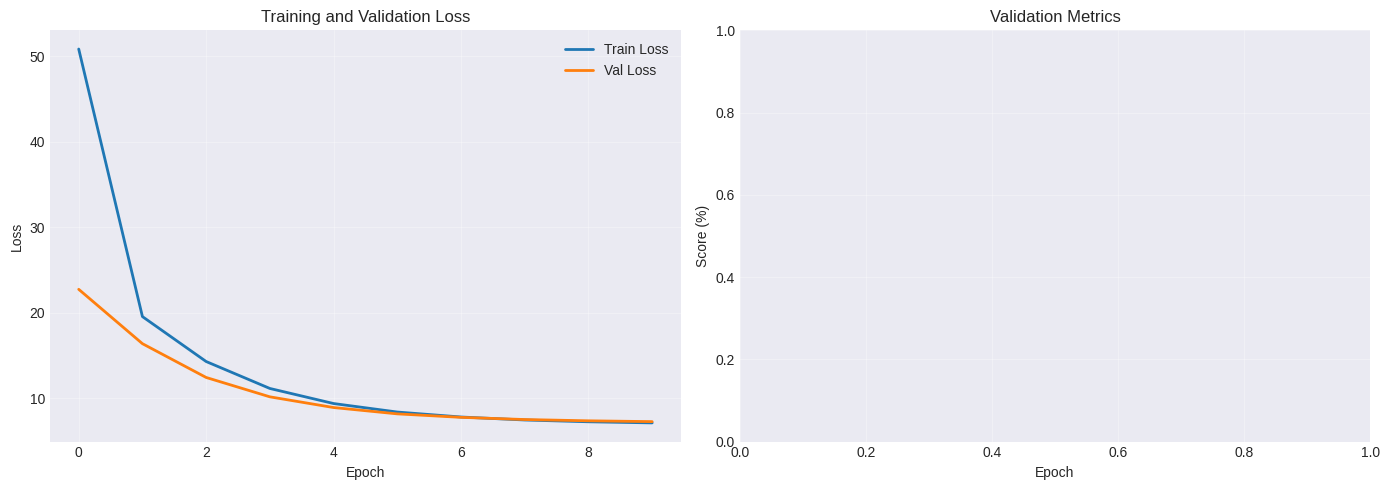


Training curves saved to checkpoints/trm_vlm_qa/training_curves.png


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Metrics (if available)
if history.get('val_em'):
    axes[1].plot(history['val_em'], label='Exact Match', linewidth=2, marker='o')
if history.get('val_f1'):
    axes[1].plot(history['val_f1'], label='Token F1', linewidth=2, marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score (%)')
axes[1].set_title('Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(ckpt_dir / "training_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTraining curves saved to {ckpt_dir / 'training_curves.png'}")

## 15. Summary and Next Steps

In [ ]:
print("\\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)

print(f"\\nModel Configuration:")
print(f"  Type: TRM VLM with Confidence-Based Recursive Refinement")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  Num layers: {NUM_LAYERS}")
print(f"  Num heads: {NUM_HEADS}")
print(f"  Inner recursion steps: {NUM_INNER_STEPS}")
print(f"  Confidence threshold: {CONFIDENCE_THRESHOLD}")
print(f"  Total parameters: {total_params:,}")

print(f"\\nTraining:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Best val loss: {best_val_loss:.4f}")

print(f"\\nEvaluation Results:")
print(f"  Exact Match (EM): {metrics['em']:.2f}%")
print(f"  Token F1: {metrics['f1']:.2f}%")
print(f"  Avg recursion steps: {avg_recursion_steps:.2f}")
print(f"  Recursion triggered: {recursion_triggered:.1f}% of tokens")

print(f"\\nDataset:")
print(f"  Train samples: {len(train_dataset):,}")
print(f"  Val samples: {len(val_dataset):,}")

print(f"\\nOutput Files:")
print(f"  Best checkpoint: {ckpt_dir / 'checkpoint_best.pt'}")
print(f"  Training curves: {ckpt_dir / 'training_curves.png'} (if saved)")

print("\\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)
print("1. TRM Recursion vs Baseline:")
print("   - TRM uses latent recursion (n inner steps) for reasoning")
print("   - Confidence-based early stopping saves computation")
print("   - Higher confidence → skip extra recursion (efficient)")
print("   - Lower confidence → trigger full recursion (quality)")
print()
print("2. Confidence Threshold Analysis:")
print(f"   - Set to {CONFIDENCE_THRESHOLD}")
print(f"   - Triggered on {recursion_triggered:.1f}% of tokens")
print("   - Can tune this for speed/quality tradeoff")
print()
print("3. Next Experiments:")
print("   - Ablation: Run with use_confidence=False (fixed recursion)")
print("   - Sweep confidence thresholds: {0.5, 0.6, 0.7, 0.8, 0.9}")
print("   - Try different inner steps: {2, 4, 6, 8}")
print("   - Add outer deep recursion (T > 1)")
print("   - Compare to baseline Tiny VLM (no TRM)")
print("="*60)

print("\\n✓ Notebook complete!")